# 1.- Cargar datos en elastic

In [50]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint
import matplotlib.pyplot as plt

es = Elasticsearch()

if not(es.indices.exists(index="prueba6-championstweet")):
    res = es.indices.create(index="prueba6-championstweet")  
    pprint(res)

In [2]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("TP5/dataset")
pprint(len(files))

354587


In [5]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('TP5/dataset/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="prueba6-championstweet", doc_type="_doc")
        tweets=[]

JSONDecodeError: Extra data: line 3 column 1 (char 3795)

# 2.- Preguntas

#### 1) En un histograma o en un line plot, visualizar el número de tweets conteniendo la palabra “goal”, cada minuto y cada 10 minutos. (BONUS: gestionar las variantes “goaaal”, “goooaallll”, etc. utilizando expresiones regulares).


In [101]:
#buscar todos los tweets con la plabra goal
res = es.search(index="prueba6-championstweet", body={"query": {"term":{"text":"goal"}}})


In [102]:
#buscar y agregar un indice para identificar el numero de tweets por minuto..
res = es.search(index="prueba6-championstweet", body={"aggs": { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})

In [103]:
#cuantos tweets con la palabra goal hay por minuto 
res = es.search(index="prueba6-championstweet", body={"query":{"term":{"text":"goal"}
                                        #no funciono la expresion regular,"regexp":{"name.first": {"value": "go+a+l+"}} 
                                                              },
                                                      "aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
                                                    
pprint(res)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'aggregations': {'tweets_over_time': {'buckets': [{'doc_count': 1,
                                                    'key': 1527340680000},
                                                   {'doc_count': 0,
                                                    'key': 1527340740000},
                                                   {'doc_count': 0,
                                                    'key': 1527340800000},
                                                   {'doc_count': 0,
                                                    'key': 1527340860000},
                                                   {'doc_count': 0,
                                                    'key': 1527340920000},
                                                   {'doc_count': 0,
                                                    'key': 1527340980000},
                                                   {'doc_count': 0,
    

                                                    'key': 1527356100000},
                                                   {'doc_count': 0,
                                                    'key': 1527356160000},
                                                   {'doc_count': 0,
                                                    'key': 1527356220000},
                                                   {'doc_count': 0,
                                                    'key': 1527356280000},
                                                   {'doc_count': 0,
                                                    'key': 1527356340000},
                                                   {'doc_count': 0,
                                                    'key': 1527356400000},
                                                   {'doc_count': 0,
                                                    'key': 1527356460000},
                                                   {'doc_count': 0,

                    '_type': '_doc'},
                   {'_id': 'h2SanWQBQiSDzgGMNIFv',
                    '_index': 'prueba6-championstweet',
                    '_score': 5.6894617,
                    '_source': {'date': 'Sat May 26 20:12:56 +0000 2018',
                                'location': 'Kaduna, Nigeria',
                                'text': 'Super goal goal goal goal goal '
                                        'https://t.co/FVh1CVOEGA',
                                'timestamp': 1527365576905,
                                'username': 'Abouuuuuuuuuuuuu Impala'},
                    '_type': '_doc'},
                   {'_id': 'IWSWnWQBQiSDzgGMrknd',
                    '_index': 'prueba6-championstweet',
                    '_score': 5.5522504,
                    '_source': {'date': 'Sat May 26 20:01:07 +0000 2018',
                                'location': 'Jordan',
                                'text': 'GOAL GOAL GOAL GOAL GOOOAAAAL '
                 

In [104]:
#crear dataframe para guardar datos de la busqueda en elastic (tweets por minuto)
import pandas as pd
df_ByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_ByMinutes = df_ByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'n_tweets'})
df_ByMinutes[:10]

,n_tweets,timestamp
0,1,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [105]:
#convertir el timestamp de milisegundos a formato horas minutos segundos
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_ByMinutes['timestamp']=df_ByMinutes['timestamp'].apply(timestamp2date)
df_ByMinutes[:10]

,n_tweets,timestamp
0,1,09:18:00
1,0,09:19:00
2,0,09:20:00
3,0,09:21:00
4,0,09:22:00
5,0,09:23:00
6,0,09:24:00
7,0,09:25:00
8,0,09:26:00
9,0,09:27:00


In [106]:
#Ordenar por el numero de tweets
df_ByMinutes_sorted=df_ByMinutes.sort_values(by=['n_tweets'], ascending=False)
df_ByMinutes_sorted[:3]

,n_tweets,timestamp
415,736,16:13:00
416,702,16:14:00
414,636,16:12:00


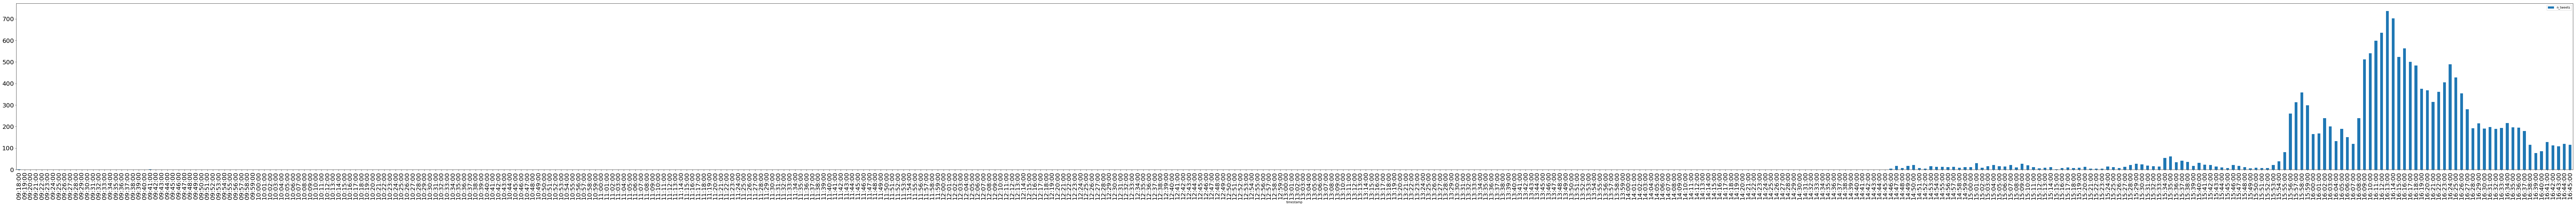

In [107]:
df_ByMinutes.plot(kind='bar',figsize=(150,10), fontsize=20, x='timestamp')
plt.show()

In [108]:
#cuantos tweets con la palabra goal hay cada 10 minutos 
res = es.search(index="prueba6-championstweet", body={"query": {"term":{"text":"goal"}},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "10m" \
                                                                                 }}}})

In [109]:
#crear dataframe para guardar datos de la busqueda (tweets cada 10 minutos)
df_By10Minutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_By10Minutes = df_By10Minutes.rename(columns={'key': 'timestamp', 'doc_count': 'n_tweets'})
df_By10Minutes[:10]

,n_tweets,timestamp
0,1,1527340200000
1,0,1527340800000
2,0,1527341400000
3,1,1527342000000
4,0,1527342600000
5,0,1527343200000
6,0,1527343800000
7,0,1527344400000
8,0,1527345000000
9,0,1527345600000


In [110]:
df_By10Minutes['timestamp']=df_By10Minutes['timestamp'].apply(timestamp2date)
df_By10Minutes[:10]

,n_tweets,timestamp
0,1,09:10:00
1,0,09:20:00
2,0,09:30:00
3,1,09:40:00
4,0,09:50:00
5,0,10:00:00
6,0,10:10:00
7,0,10:20:00
8,0,10:30:00
9,0,10:40:00


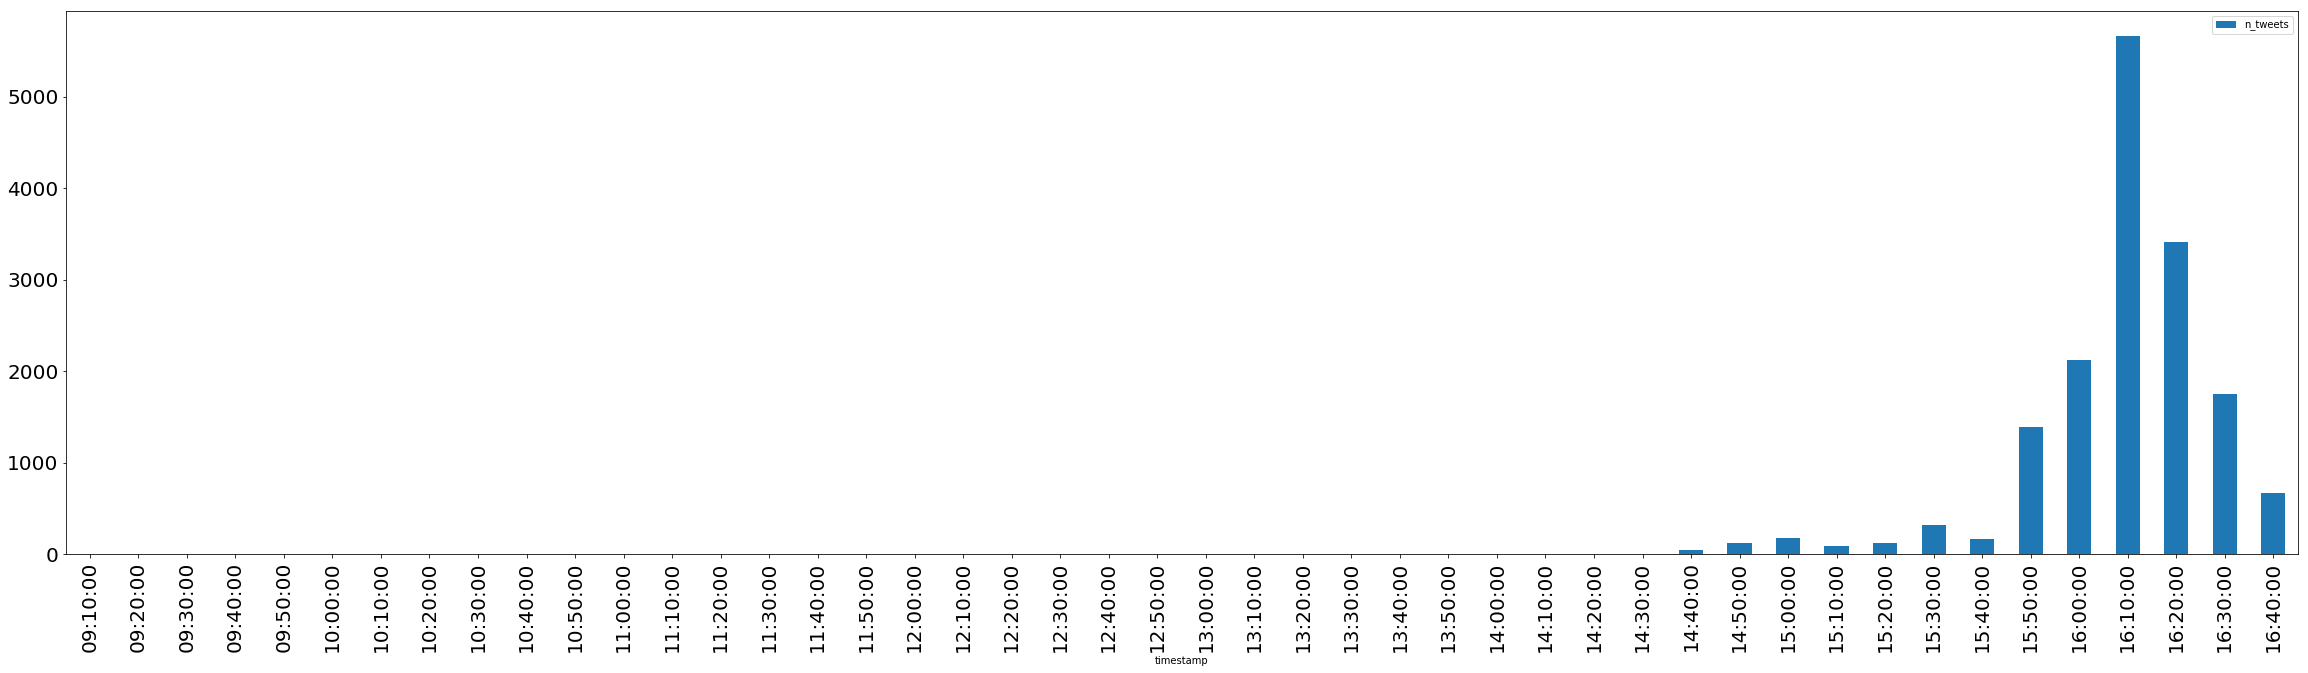

In [111]:
df_By10Minutes.plot(kind='bar',figsize=(40,10), fontsize=20, x='timestamp')
plt.show()

### 2)En un histograma o en un line plot, visualizar dos series de datos:
#### A)el número de tweets que hablan de ‘liverpool’ por cada minuto,

In [156]:
#cuantos tweets con la palabra liverpool hay por minuto 
res = es.search(index="prueba6-championstweet",
                body={
                    "query":{
                        "term":{
                            "text":"liverpool"
                        }
                    },
                    "aggs":{
                        "tweets_over_time":{
                            "date_histogram":{
                                "field":"timestamp","interval":"1m"
                            }
                        }
                    }
                }
               )

In [157]:
#crear dataframe para guardar datos de la busqueda (tweets de liverpool)
df_liverpool = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_liverpool = df_liverpool.rename(columns={'key': 'timestamp', 'doc_count': 'n_tweets'})
df_liverpool[:5]

,n_tweets,timestamp
0,4,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000


In [158]:
df_liverpool['timestamp']=df_liverpool['timestamp'].apply(timestamp2date)
df_liverpool[:5]

,n_tweets,timestamp
0,4,09:18:00
1,0,09:19:00
2,0,09:20:00
3,0,09:21:00
4,0,09:22:00


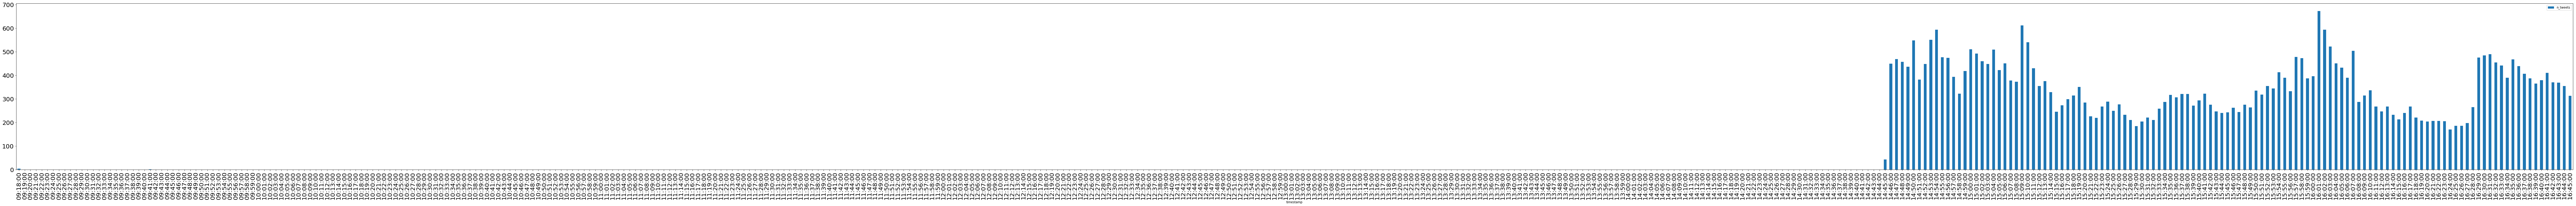

In [159]:
df_liverpool.plot(kind='bar',figsize=(150,10), fontsize=20, x='timestamp')
plt.show()

In [160]:
#cuantos tweets con la palabra madrid hay por minuto 
res = es.search(index="prueba6-championstweet",
                body={
                    "query":{
                        "term":{"text":"madrid"}
                    },
                    "aggs":{
                        "tweets_over_time":{ 
                            "date_histogram":{
                                "field":"timestamp","interval":"1m"
                            }
                        }
                    }
                }
               )

In [161]:
#crear dataframe para guardar datos de la busqueda (tweets de madrid)
df_madrid = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_madrid = df_madrid.rename(columns={'key': 'timestamp', 'doc_count': 'n_tweets'})
df_madrid[:10]

,n_tweets,timestamp
0,5,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [162]:
df_madrid['timestamp']=df_madrid['timestamp'].apply(timestamp2date)
df_madrid[:10]

,n_tweets,timestamp
0,5,09:18:00
1,0,09:19:00
2,0,09:20:00
3,0,09:21:00
4,0,09:22:00
5,0,09:23:00
6,0,09:24:00
7,0,09:25:00
8,0,09:26:00
9,0,09:27:00


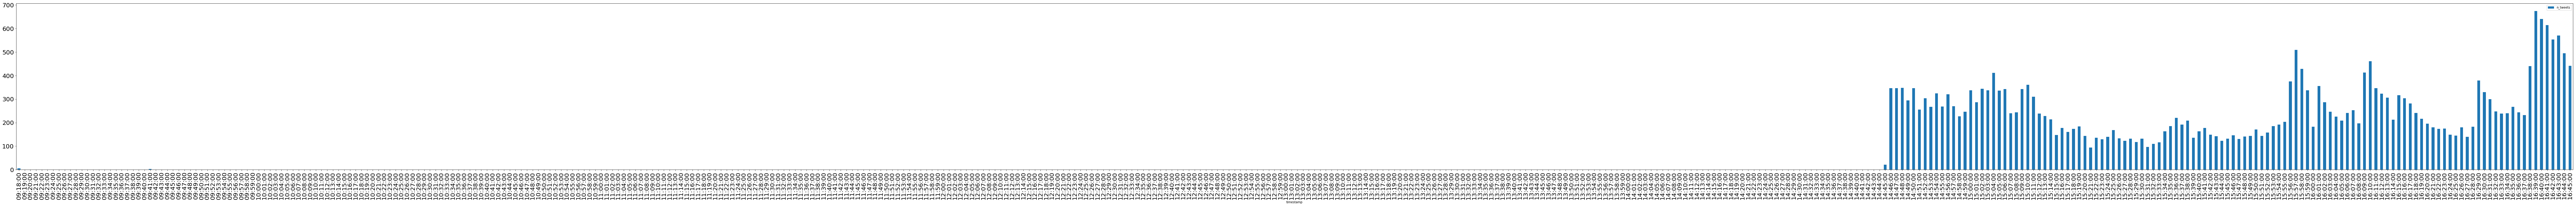

In [163]:
df_madrid.plot(kind='bar',figsize=(150,10), fontsize=20, x='timestamp')
plt.show()

In [167]:
#uniendo los 2 dataframes
df_ex2=df_liverpool.merge(df_madrid,on='timestamp')
df_ex2= df_ex2.rename(columns={'n_tweets_x': 'n_tweets_liverpool', 'n_tweets_y': 'n_tweets_madrid'})
df_ex2[:5]

,n_tweets_liverpool,timestamp,n_tweets_madrid
0,4,09:18:00,5
1,0,09:19:00,0
2,0,09:20:00,0
3,0,09:21:00,0
4,0,09:22:00,0


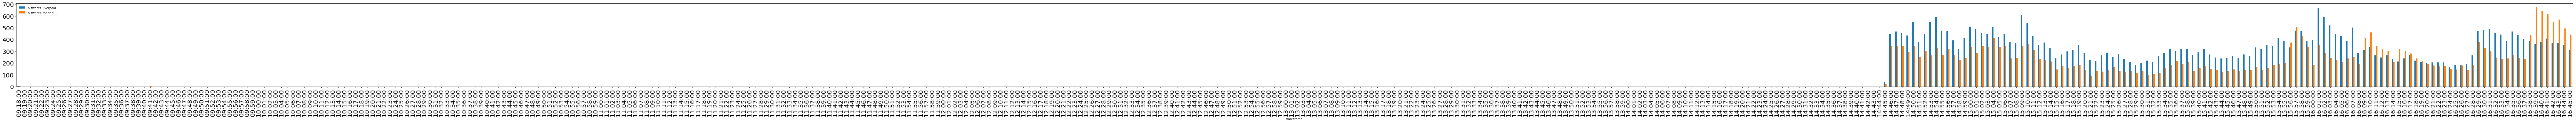

In [168]:
df_ex2.plot(kind='bar',figsize=(150,5),fontsize=20,x='timestamp')
plt.show()

### ¿A qué minuto se habla más de Madrid?

en minuto 39 de las 4 de la tarde

### 3)En un dataframe, mostrar el número de tweets según el país indicado en el campo ‘location’. ¿Desde cuáles países se enviaron los tweets? (BONUS: mostrar los resultados en una mapa).

In [176]:
res = es.search(index="prueba6-championstweet",
                body={
                    "query":{
                        "match_all":{}
                    },
                    "aggs":{
                        "country":{
                            "terms":{
                                "field":"location.keyword"
                            }
                        }
                    }
                }
               )
#pprint(res)

In [182]:
df_location = pd.DataFrame(res['aggregations']['country']['buckets'])
df_location[:15]

,doc_count,key
0,3312,"Lagos, Nigeria"
1,2419,Nigeria
2,1844,"London, England"
3,1668,"Nairobi, Kenya"
4,1567,South Africa
5,1364,"Johannesburg, South Africa"
6,1139,London
7,970,Brasil
8,954,United Kingdom
9,899,"Rio de Janeiro, Brasil"


### 4)  En un histograma o en un line plot, visualizar dos series de datos:
#### a) el número de tweets enviado desde Inglaterra, por cada minuto.


In [137]:
res = es.search(index="prueba6-championstweet",
                body={
                    "query": {
                        "match": {
                            "location":"england"
                        }
                    },
                    "aggs":{
                        "tweets_over_time":{
                            "date_histogram":{ 
                                "field":"timestamp","interval":"1m"
                            }
                        }
                    }
                }
               )
#pprint(res)

In [138]:
df_eng = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_eng = df_eng.rename(columns={'key': 'timestamp', 'doc_count': 'n_tweets'})
df_eng[:10]

,n_tweets,timestamp
0,1,1527342060000
1,0,1527342120000
2,0,1527342180000
3,0,1527342240000
4,0,1527342300000
5,0,1527342360000
6,0,1527342420000
7,0,1527342480000
8,0,1527342540000
9,0,1527342600000


In [139]:
df_eng['timestamp']=df_eng['timestamp'].apply(timestamp2date)
df_eng[:10]

,n_tweets,timestamp
0,1,09:41:00
1,0,09:42:00
2,0,09:43:00
3,0,09:44:00
4,0,09:45:00
5,0,09:46:00
6,0,09:47:00
7,0,09:48:00
8,0,09:49:00
9,0,09:50:00


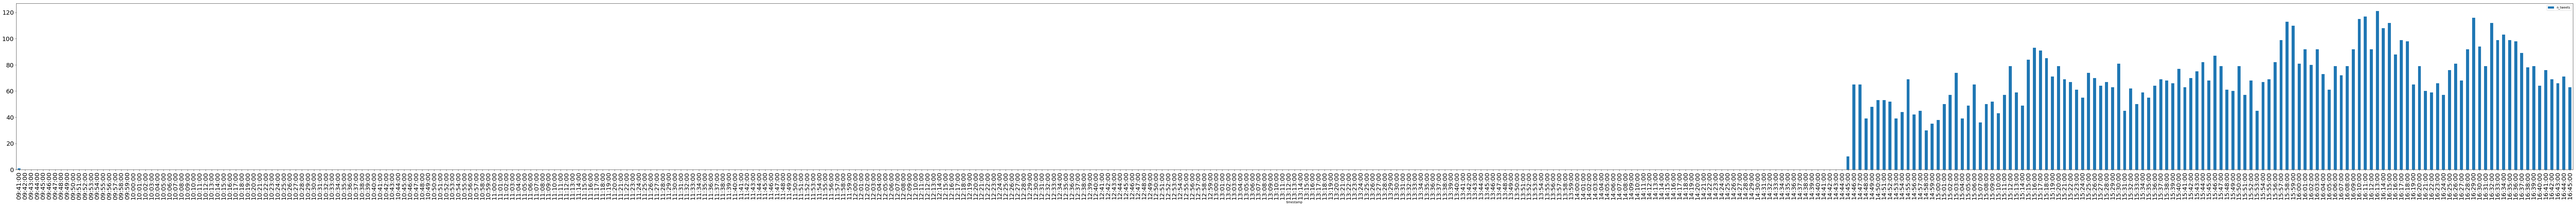

In [140]:
df_eng.plot(kind='bar',figsize=(150,10), fontsize=20, x='timestamp')
plt.show()

#### 2) el número de tweets enviado desde España, por cada minuto.

In [169]:
res = es.search(index="prueba6-championstweet",
                body={
                    "query": {
                        "match": {
                            "location":"spain"
                        }
                    },
                    "aggs":{
                        "tweets_over_time":{
                            "date_histogram":{ 
                                "field":"timestamp","interval":"1m"
                            }
                        }
                    }
                }
               )
#pprint(res)

In [170]:
df_spa = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_spa = df_spa.rename(columns={'key': 'timestamp', 'doc_count': 'n_tweets'})
df_spa[:10]

,n_tweets,timestamp
0,1,1527342060000
1,0,1527342120000
2,0,1527342180000
3,0,1527342240000
4,0,1527342300000
5,0,1527342360000
6,0,1527342420000
7,0,1527342480000
8,0,1527342540000
9,0,1527342600000


In [171]:
df_spa['timestamp']=df_spa['timestamp'].apply(timestamp2date)
df_spa[:10]

,n_tweets,timestamp
0,1,09:41:00
1,0,09:42:00
2,0,09:43:00
3,0,09:44:00
4,0,09:45:00
5,0,09:46:00
6,0,09:47:00
7,0,09:48:00
8,0,09:49:00
9,0,09:50:00


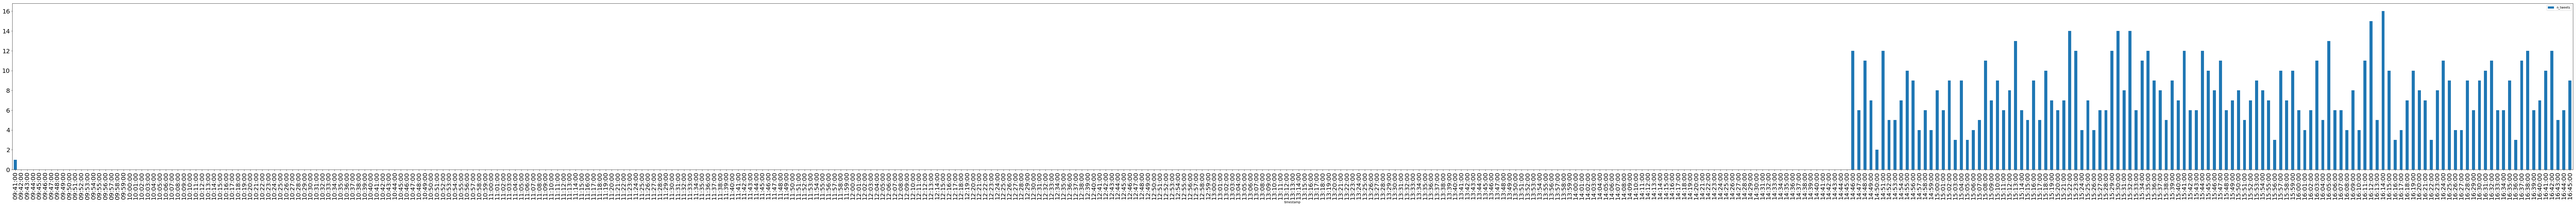

In [144]:
df_spa.plot(kind='bar',figsize=(150,10), fontsize=20, x='timestamp')
plt.show()

In [172]:
#uniendo los 2 dataframes
df_ex4=df_eng.merge(df_spa,on='timestamp')
df_ex4= df_ex4.rename(columns={'n_tweets_x': 'n_tweets_england', 'n_tweets_y': 'n_tweets_spain'})
df_ex4[:5]

,n_tweets_england,timestamp,n_tweets_spain
0,1,09:41:00,1
1,0,09:42:00,0
2,0,09:43:00,0
3,0,09:44:00,0
4,0,09:45:00,0


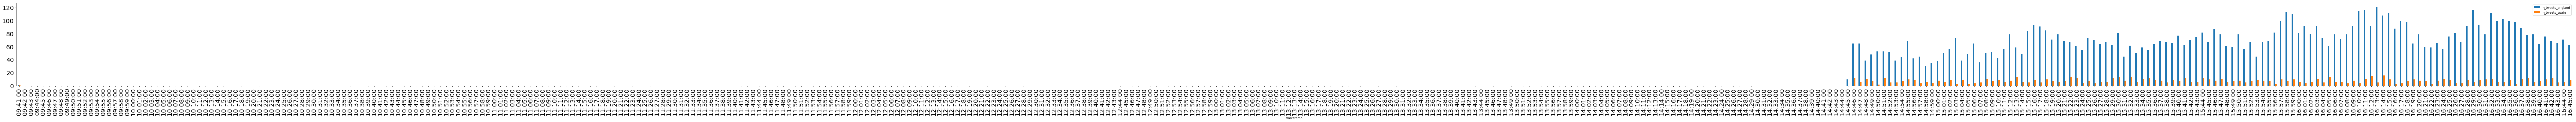

In [173]:
df_ex4.plot(kind='bar',figsize=(150,5),fontsize=20,x='timestamp')
plt.show()

### 5) ¿Cómo podríamos analizar las emociones expresadas durante el partido? Proponer una metodología para responder a esta pregunta. (No es obligatorio implementar su metodología pero debe ser factible con las tecnologías que conocen). 

podriamos ver el contendio del texto del tweet y comparar palabras con una lista asignada por emocion (alegria,enojo,preocupada, etc..) luego crear dataframes por tweet y sus respectivas emociones y juntarlos en un solo histograma, o podriamos (por efectos de la prueba) asignar un puntaje a como esta escrita la palabra goal mientras mas larga la palabra podriamos definir una escala de felicidad.